#### Data Sources and Literature

Source: https://archive.ics.uci.edu/ml/datasets/Estimation+of+obesity+levels+based+on+eating+habits+and+physical+condition+

Publication: https://www.sciencedirect.com/science/article/pii/S2352340919306985?via%3Dihub

#### Research Question

Question: Is risk of obesity characterized by lifestyle and demographic attributes?

## Data Exploration

In [1]:
#imported all the required modules
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from pathlib import Path
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.preprocessing import label_binarize

**1. Load dataset**

In [3]:
# Load dataset
df = pd.read_csv('/content/Obesity.csv')

FileNotFoundError: [Errno 2] No such file or directory: '/content/Obesity.csv'

**2. Inspecting the features**

In [ ]:
#Look at first few rows
df.head()

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,Female,21.0,1.62,64.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,0.0,1.0,no,Public_Transportation,Normal_Weight
1,Female,21.0,1.52,56.0,yes,no,3.0,3.0,Sometimes,yes,3.0,yes,3.0,0.0,Sometimes,Public_Transportation,Normal_Weight
2,Male,23.0,1.80,77.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,2.0,1.0,Frequently,Public_Transportation,Normal_Weight
3,Male,27.0,1.80,87.0,no,no,3.0,3.0,Sometimes,no,2.0,no,2.0,0.0,Frequently,Walking,Overweight_Level_I
4,Male,22.0,1.78,89.8,no,no,2.0,1.0,Sometimes,no,2.0,no,0.0,0.0,Sometimes,Public_Transportation,Overweight_Level_II


In [ ]:
#Identify columns and their datatypes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2111 entries, 0 to 2110
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Gender                          2111 non-null   object 
 1   Age                             2111 non-null   float64
 2   Height                          2111 non-null   float64
 3   Weight                          2111 non-null   float64
 4   family_history_with_overweight  2111 non-null   object 
 5   FAVC                            2111 non-null   object 
 6   FCVC                            2111 non-null   float64
 7   NCP                             2111 non-null   float64
 8   CAEC                            2111 non-null   object 
 9   SMOKE                           2111 non-null   object 
 10  CH2O                            2111 non-null   float64
 11  SCC                             2111 non-null   object 
 12  FAF                             21

In [ ]:
#Basic descriptive statistics about numeric columns
df.describe()

,Age,Height,Weight,FCVC,NCP,CH2O,FAF,TUE
count,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000
mean,24.312600,1.701677,86.586058,2.419043,2.685628,2.008011,1.010298,0.657866
std,6.345968,0.093305,26.191172,0.533927,0.778039,0.612953,0.850592,0.608927
min,14.000000,1.450000,39.000000,1.000000,1.000000,1.000000,0.000000,0.000000
25%,19.947192,1.630000,65.473343,2.000000,2.658738,1.584812,0.124505,0.000000
50%,22.777890,1.700499,83.000000,2.385502,3.000000,2.000000,1.000000,0.625350
75%,26.000000,1.768464,107.430682,3.000000,3.000000,2.477420,1.666678,1.000000
max,61.000000,1.980000,173.000000,3.000000,4.000000,3.000000,3.000000,2.000000


In [ ]:
#Look for missing values
df.isnull().sum()

Gender                            0
Age                               0
Height                            0
Weight                            0
family_history_with_overweight    0
FAVC                              0
FCVC                              0
NCP                               0
CAEC                              0
SMOKE                             0
CH2O                              0
SCC                               0
FAF                               0
TUE                               0
CALC                              0
MTRANS                            0
NObeyesdad                        0
dtype: int64

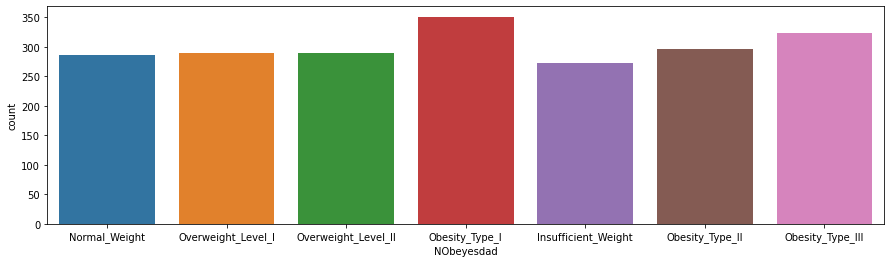

In [ ]:
#Plot the relative distribution of the dependent varible, NObeyesdad
plt.figure(figsize=(15,4))
sns.countplot(x='NObeyesdad', data=df)

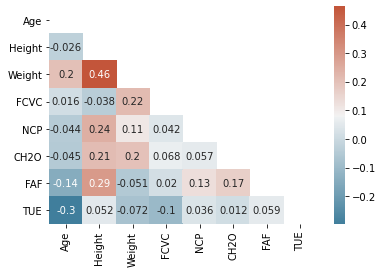

In [ ]:
#Identify which features are correlated to determine if there is any potential issues for multicollinearity
corr_df = df.corr()
mask = np.triu(np.ones_like(corr_df, dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr_df, annot=True, mask = mask, cmap=cmap)

Correlation plots are useful for identifying features that may have issue with multicollinearity. Features that have a correlation coefficient of > 0.7 are typically a cause for concern. The features in this dataset do not show any signs of significant correlation. 

In [ ]:
#Isolate just numeric columns
numeric = df.select_dtypes(include='float64')

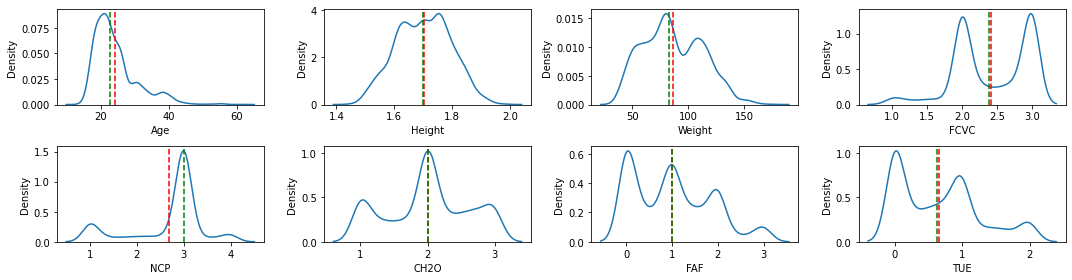

In [ ]:
#Create distribution plots to identify if any numeric columns are skewed
f, axes = plt.subplots(2, 4, figsize=(15,4))

for i, ax in zip(numeric.columns, axes.flat):
    sns.distplot(numeric[i], hist=False, ax=ax)
    mean = np.nanmean(numeric[i])
    median = np.nanmedian(numeric[i])
    n_bins = np.sqrt(len(numeric[i]))
    ax.axvline(mean, color = 'red', label = 'mean', linestyle = 'dashed')
    ax.axvline(median, color = 'green', label = 'median', linestyle = 'dashed')
plt.tight_layout()
plt.show()

From these distribution plots we can identify that none of the numeric variables suffer from skewness

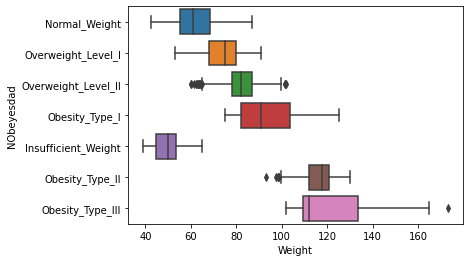

In [ ]:
#Bivariate boxplots of weight vs obesity categories
sns.boxplot(df['Weight'], y=df['NObeyesdad'])

This boxplot above indicates that some of the individuals in the dataset have weights that are outlier. Further data cleaning will be done to remove these.

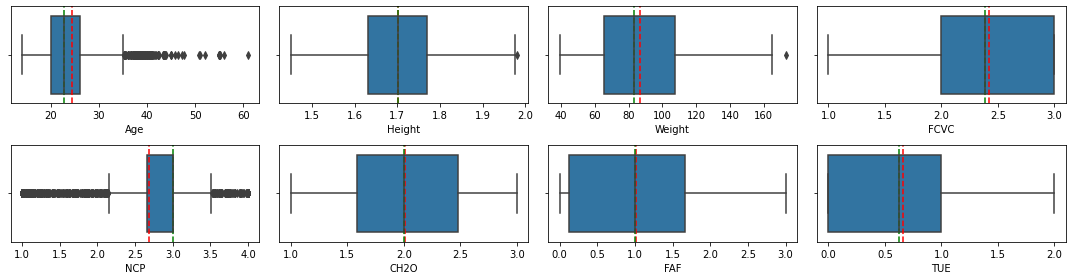

In [ ]:
f, axes = plt.subplots(2, 4, figsize=(15,4))

for i, ax in zip(numeric.columns, axes.flat):
    sns.boxplot(numeric[i], ax=ax)
    mean = np.nanmean(numeric[i])
    median = np.nanmedian(numeric[i])
    n_bins = np.sqrt(len(numeric[i]))
    ax.axvline(mean, color = 'red', label = 'mean', linestyle = 'dashed')
    ax.axvline(median, color = 'green', label = 'median', linestyle = 'dashed')
plt.tight_layout()
plt.show()

Here we can see that the columns, Age, NCP, Height, and Weight have some outliers that we need to remove

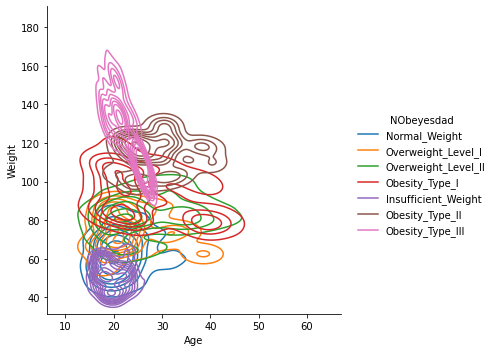

In [ ]:
#Visualize how age and weight are factors of obesity categories
sns.displot(df, x='Age', y='Weight', hue='NObeyesdad', kind='kde')

In [2]:
#Isolate just categorical columns
cat = df.select_dtypes(include='object')

NameError: name 'df' is not defined

**3. Data Preparation and Preprocessing**

The data preprocessing is needed before we proceed towards building our machine learning model. We are going to divide the preprocessing steps into three main tasks:


*   Transform the numeric values of NCP feature into catagorical value as 
described below.

      The column NCP looks to be incorrectly formatted as a continuous variable. From the literature, it should be a categorical variable with 3 groups: 1-2 meals, 3 meals, and >3 meals. 

        0-2 meals = Low
        2-3 meals = Medium
        Over 3 = High
*   Scale the feature values to a uniform range.
*   Convert the catagorical variable with two values to binary and catagorical 
variable with mutliple values need, dummy variable coding.
*   Split the data into train and test sets.





In [ ]:
df['NCP'] = np.where(df['NCP'] >3, 'High', np.where(df['NCP'] <=2, 'Low', 'Medium'))

####**4. Outlier Removal**

As we saw earlier, some features have outliers that need to be removed. We can detect and remove using IQR

In [ ]:
def calc_IQR_limits(df, column):
  perc_25 = df[column].quantile(0.25)
  perc_75 = df[column].quantile(0.75)

  IQR = perc_75 - perc_25

  upper_limit = perc_75 + 1.5 * IQR
  lower_limit = perc_25 - 1.5 * IQR

  return upper_limit, lower_limit

In [ ]:
outlier_cols = ['Age', 'Height', 'Weight']

for col in outlier_cols:
  upper_limit, lower_limit = calc_IQR_limits(df, col)
  df = df[df[col] < upper_limit]
  df = df[df[col] > lower_limit]

In [ ]:
numeric = df.select_dtypes(include='float64')

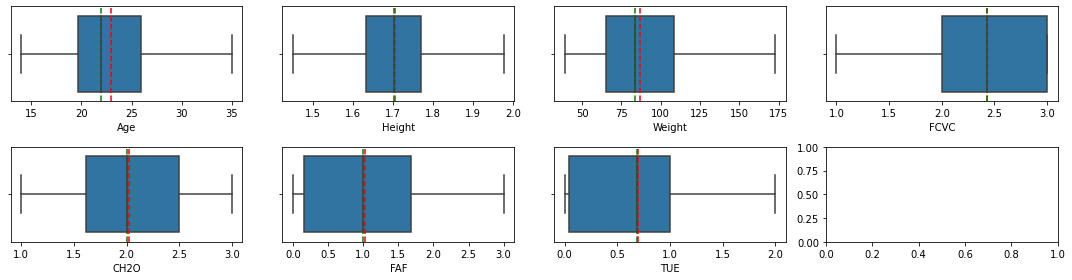

In [ ]:
f, axes = plt.subplots(2, 4, figsize=(15,4))

for i, ax in zip(numeric.columns, axes.flat):
    sns.boxplot(numeric[i], ax=ax)
    mean = np.nanmean(numeric[i])
    median = np.nanmedian(numeric[i])
    n_bins = np.sqrt(len(numeric[i]))
    ax.axvline(mean, color = 'red', label = 'mean', linestyle = 'dashed')
    ax.axvline(median, color = 'green', label = 'median', linestyle = 'dashed')
plt.tight_layout()
plt.show()

boxplot without the outliers

#### **5. Label Encoding and Dummy Variables**

Need to convert categorical variables into numeric representations. Columns that are binary will be converted into 1's and 0's, multiclass variables will be converted into dummy variables

In [ ]:
#Isolate binary columns and convert to 1's and 0's
def convert_to_binary(df, column, word):
  df[column] = np.where(df[column] == word, 1, 0)
  return df

In [ ]:
binary_cols = ['family_history_with_overweight', 'FAVC', 'SMOKE', 'SCC']

for val in binary_cols:
  convert_to_binary(df, val, 'yes')

In [ ]:
#convert gender column to 0's and 1's
convert_to_binary(df, 'Gender', 'Female')

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,1,21.000000,1.620000,64.000000,1,0,2.0,Medium,Sometimes,0,2.000000,0,0.000000,1.000000,no,Public_Transportation,Normal_Weight
1,1,21.000000,1.520000,56.000000,1,0,3.0,Medium,Sometimes,1,3.000000,1,3.000000,0.000000,Sometimes,Public_Transportation,Normal_Weight
2,0,23.000000,1.800000,77.000000,1,0,2.0,Medium,Sometimes,0,2.000000,0,2.000000,1.000000,Frequently,Public_Transportation,Normal_Weight
3,0,27.000000,1.800000,87.000000,0,0,3.0,Medium,Sometimes,0,2.000000,0,2.000000,0.000000,Frequently,Walking,Overweight_Level_I
4,0,22.000000,1.780000,89.800000,0,0,2.0,Low,Sometimes,0,2.000000,0,0.000000,0.000000,Sometimes,Public_Transportation,Overweight_Level_II
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2106,1,20.976842,1.710730,131.408528,1,1,3.0,Medium,Sometimes,0,1.728139,0,1.676269,0.906247,Sometimes,Public_Transportation,Obesity_Type_III
2107,1,21.982942,1.748584,133.742943,1,1,3.0,Medium,Sometimes,0,2.005130,0,1.341390,0.599270,Sometimes,Public_Transportation,Obesity_Type_III
2108,1,22.524036,1.752206,133.689352,1,1,3.0,Medium,Sometimes,0,2.054193,0,1.414209,0.646288,Sometimes,Public_Transportation,Obesity_Type_III
2109,1,24.361936,1.739450,133.346641,1,1,3.0,Medium,Sometimes,0,2.852339,0,1.139107,0.586035,Sometimes,Public_Transportation,Obesity_Type_III


In [ ]:
df = pd.get_dummies(df, columns=['NCP', 'CAEC', 'CALC', 'MTRANS'])

In [ ]:
#Label encode the target variable: NObeyesdad
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

df['NObeyesdad'] = le.fit_transform(df['NObeyesdad'])

In [ ]:
print(le.classes_)
print("""
Class 0: Insufficient_Weight
Class 1: Normal_Weight
Class 2: Obesity_Type_I
Class 3: Obesity_Type_II
Class 4: Obesity_Type_III
Class 5: Overweight_Level_I
Class 6: Overweight_Level_II
"""
)

['Insufficient_Weight' 'Normal_Weight' 'Obesity_Type_I' 'Obesity_Type_II'
 'Obesity_Type_III' 'Overweight_Level_I' 'Overweight_Level_II']

Class 0: Insufficient_Weight
Class 1: Normal_Weight
Class 2: Obesity_Type_I
Class 3: Obesity_Type_II
Class 4: Obesity_Type_III
Class 5: Overweight_Level_I
Class 6: Overweight_Level_II



In [ ]:
df.head()

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,SMOKE,CH2O,SCC,FAF,TUE,NObeyesdad,NCP_High,NCP_Low,NCP_Medium,CAEC_Always,CAEC_Frequently,CAEC_Sometimes,CAEC_no,CALC_Always,CALC_Frequently,CALC_Sometimes,CALC_no,MTRANS_Automobile,MTRANS_Bike,MTRANS_Motorbike,MTRANS_Public_Transportation,MTRANS_Walking
0,1,21.0,1.62,64.0,1,0,2.0,0,2.0,0,0.0,1.0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0
1,1,21.0,1.52,56.0,1,0,3.0,1,3.0,1,3.0,0.0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0
2,0,23.0,1.80,77.0,1,0,2.0,0,2.0,0,2.0,1.0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0
3,0,27.0,1.80,87.0,0,0,3.0,0,2.0,0,2.0,0.0,5,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,1
4,0,22.0,1.78,89.8,0,0,2.0,0,2.0,0,0.0,0.0,6,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0


**6. Splitting the dataset into train and test sets**

We have successfully all the necessary data preprocessing.

Now, we will split our data into train set and test set to prepare our data for two different phases of machine learning modeling: training and testing. Ideally, no information from the test data should be used to scale the training data or should be used to direct the training process of a machine learning model. Hence, we first split the data and then apply the scaling.

In [ ]:
from sklearn.model_selection import train_test_split

X = df.loc[:, df.columns != 'NObeyesdad']
y = df['NObeyesdad']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

#### **7. Scale Training Data**
The data is now split into two separate sets - train and test sets respectively. We are only left with one final preprocessing step of scaling before we can fit a machine learning model to the data.

Now, let's try to understand what these scaled values mean, it is a measurement variable — a variable that has a numeric value. This could be an issue if you’ve assigned numbers to represent categories, so you should define each variable within the measurement area individually. 


In [ ]:
#Scale only columns that are continuous variables
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

continuous_cols = X_train.select_dtypes(include='float64').columns

X_train[continuous_cols] = scaler.fit_transform(X_train[continuous_cols])

#### Fit scaler to testing data

In [ ]:
#Fit scaler to testing data
test_continuous_col = X_test.select_dtypes(include='float64').columns

X_test[test_continuous_col] = scaler.transform(X_test[test_continuous_col])

## Modeling

#### Train support vector classifier and Random Forest using GridSearchCV

In [ ]:
#create a dictionary of hyperparameters to try
svc_params = {'kernel': ('linear', 'poly', 'rbf'),
          'C': (1.0, 0.8, 0.6, 0.4, 0.2, 0.1, 0.01),
          'degree': (5,4,3,2,1)}

#instantiate an SVC to be the estimator
svc = SVC()

#Create a GridSearchCV to try all hyperparameters
grid_svc = GridSearchCV(estimator=svc,
                       param_grid=svc_params,
                       scoring='accuracy',
                       cv=5,
                       verbose=1,
                       n_jobs=-1)

#Fit each version of the SVC to the training data
grid_svc.fit(X_train, y_train)

Fitting 5 folds for each of 105 candidates, totalling 525 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done 368 tasks      | elapsed:   17.5s
[Parallel(n_jobs=-1)]: Done 522 out of 525 | elapsed:   27.5s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 525 out of 525 | elapsed:   27.7s finished


GridSearchCV(cv=5, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'C': (1.0, 0.8, 0.6, 0.4, 0.2, 0.1, 0.01),
                         'degree': (5, 4, 3, 2, 1),
                         'kernel': ('linear', 'poly', 'rbf')},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accuracy', verbose=1)

In [ ]:
#output the best hyperparameters from the GridSearchCV
grid_svc.best_params_

{'C': 1.0, 'degree': 5, 'kernel': 'linear'}

In [ ]:
#predict new outputs with the testing data
grid_svc_pred = grid_svc.predict(X_test)

#output a confusion matrix for those predictions
confusion_matrix(y_test, grid_svc_pred)

array([[ 91,   4,   0,   0,   0,   0,   0],
       [  8,  72,   0,   0,   0,   3,   0],
       [  0,   0,  98,   3,   0,   0,   1],
       [  0,   0,   1,  90,   1,   0,   0],
       [  0,   0,   0,   0, 108,   0,   0],
       [  0,   4,   0,   0,   0,  73,   4],
       [  0,   0,   3,   0,   0,   5,  72]])

In [ ]:
#create a Random Forest Classifier to use as the estimator
rf = RandomForestClassifier()

#create another dictionary of valid hyperparameters to try
params_rf = {
    'max_depth':[20,30,40,50],
    'min_samples_leaf':[0.01, 0.05, 0.1, 0.2],
    'n_estimators':[50, 100, 150, 200]
}

#instantiate the GridSearchCV
grid_rf = GridSearchCV(estimator=rf,
                       param_grid=params_rf,
                       scoring='accuracy',
                       cv=5,
                       verbose=1,
                       n_jobs=-1)

#fit the GridSearchCV to our training data
grid_rf.fit(X_train, y_train)

Fitting 5 folds for each of 64 candidates, totalling 320 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    9.0s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:   38.3s
[Parallel(n_jobs=-1)]: Done 320 out of 320 | elapsed:  1.0min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rando

In [ ]:
#output the best hyperparameters from the GridSearchCV
grid_rf.best_params_

{'max_depth': 20, 'min_samples_leaf': 0.01, 'n_estimators': 150}

In [ ]:
#predict new outputs with the testing data
grid_rf_pred = grid_rf.predict(X_test)

#output a confusion matrix for those predictions
confusion_matrix(y_test, grid_rf_pred)

array([[ 85,   8,   0,   0,   0,   2,   0],
       [  7,  64,   0,   0,   0,   8,   4],
       [  0,   2,  84,  10,   0,   3,   3],
       [  0,   0,   1,  90,   1,   0,   0],
       [  0,   0,   0,   0, 108,   0,   0],
       [  1,  14,   2,   0,   0,  57,   7],
       [  0,  10,   2,   2,   0,   6,  60]])

In [ ]:
#output information comparing the accuracy of the two models
print("Accuracy of Support Vector Classifier:", '{:.1%}'.format(grid_svc.score(X_test, y_test)))
print("Accuracy of Random Forest Classifier:", '{:.1%}'.format(grid_rf.score(X_test, y_test)))

Accuracy of Support Vector Classifier: 94.2%
Accuracy of Random Forest Classifier: 85.5%


In [ ]:
#create and output Classification Reports of both models
print('SVC Classification Report')
print(classification_report(y_test, grid_svc_pred))
print('Random Forest Classification Report')
print(classification_report(y_test, grid_rf_pred))

SVC Classification Report
              precision    recall  f1-score   support

           0       0.92      0.96      0.94        95
           1       0.90      0.87      0.88        83
           2       0.96      0.96      0.96       102
           3       0.97      0.98      0.97        92
           4       0.99      1.00      1.00       108
           5       0.90      0.90      0.90        81
           6       0.94      0.90      0.92        80

    accuracy                           0.94       641
   macro avg       0.94      0.94      0.94       641
weighted avg       0.94      0.94      0.94       641

Random Forest Classification Report
              precision    recall  f1-score   support

           0       0.91      0.89      0.90        95
           1       0.65      0.77      0.71        83
           2       0.94      0.82      0.88       102
           3       0.88      0.98      0.93        92
           4       0.99      1.00      1.00       108
           5    

Both models overall performed very well. The SVC model performed the best, managing to accurately predict over 94% of target class. This shows that the features within this dataset are highly predictive of whether or not someone leads an unhealthy lifestyle

In [ ]:
class_dict = {
  0: 'Insufficient_Weight',
  1: 'Normal_Weight',
  2: 'Obesity_Type_I',
  3: 'Obesity_Type_II',
  4: 'Obesity_Type_III',
  5: 'Overweight_Level_I',
  6: 'Overweight_Level_II',
}

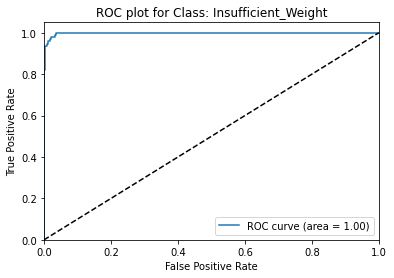

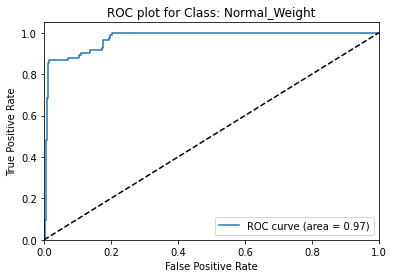

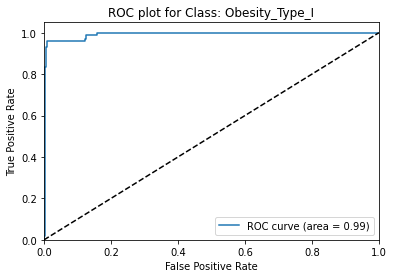

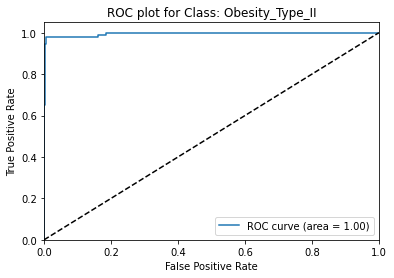

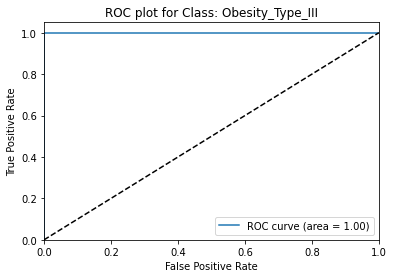

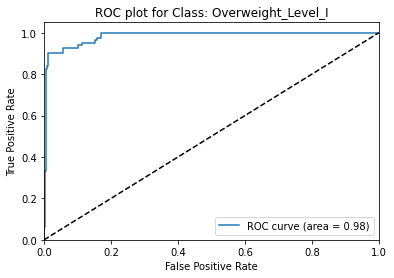

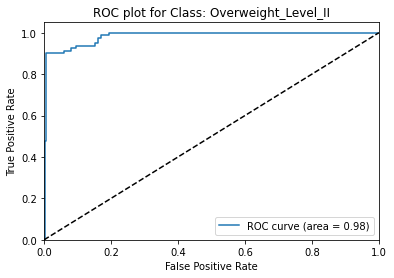

In [ ]:
y_bin = label_binarize(y, classes=[0, 1, 2, 3, 4, 5, 6])
n_classes = y_bin.shape[1]

y_score = grid_svc.decision_function(X_test)

y_dum = pd.get_dummies(y_test, drop_first=False).values

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_dum[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

for i in range(n_classes):
    plt.figure()
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC plot for Class: {}'.format(class_dict[i]))
    plt.legend(loc="lower right")
    plt.show()